# Automated Extraction of Quotations From Text - Model Training

The purpose is to train 1 baseline model using machine learning with logistic regressions, and 2 deep learning models using Recurrent Neural Network (RNN) and Bidirectional Encoder from Transformers (BERT) models. The performances of the models are compared and the best model is selected for deployment later.

## Prepare Data

### Load Libraries

In [ ]:
!pip install --quiet transformers

     |████████████████████████████████| 4.7 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 69.8 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 6.6 MB 50.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import transformers

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import re
import nltk
import gensim
import gensim.downloader as api

from datetime import datetime
# from google.colab import files
import pickle

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### Load Data

In [ ]:
df = pd.read_csv('quotes-prepared-40000.csv')

In [ ]:
df.rename(columns={"quote": "category"}, inplace=True)
df = df[["category", "text"]]

# Show the data
df.head()

,category,text
0,1,Color is an intense experience on its own.
1,1,God takes great joy in the passionate romantic...
2,1,"No jealousy their dawn of love overcast, nor b..."
3,0,The sound mockery of sheep is like the salubri...
4,1,Players have two things to do: Play and keep t...


### Explore Data

In [ ]:
print('Total number of text: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["category"].value_counts())
print(40*'-')
nr_categories = len(df["category"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of text: 29600
----------------------------------------
Split by category:
1    14800
0    14800
Name: category, dtype: int64
----------------------------------------
Number of categories: 2


In [ ]:
# You can adjust n:
n=100
print('Category: ',df['category'][n])
print(100*'-')
print('Text:')
print(df['text'][n])

Category:  0
----------------------------------------------------------------------------------------------------
Text:
During the return trip, Barco kept muttering to himself in meaningless phrases, such as: "They're under sand dunes They're better off, I tell you I saved their souls".


### Proprocess Data

In [ ]:
# Reference: Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT from Medium

# Use stopwords list from nltk (that is used in the function below)
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
# Let's apply this function to the whole corpus
df["text_clean"] = df["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

# Let's look at the output
df.head()

,category,text,text_clean
0,1,Color is an intense experience on its own.,color intense experience
1,1,God takes great joy in the passionate romantic...,god take great joy passionate romantic love hu...
2,1,"No jealousy their dawn of love overcast, nor b...",jealousy dawn love overcast blasted wedded day...
3,0,The sound mockery of sheep is like the salubri...,sound mockery sheep like salubrious horse laugh
4,1,Players have two things to do: Play and keep t...,player two thing play keep mouth shut


### Test Data

In [ ]:
text_test = [
  'A journey of a thousand miles begins with a single step.',
  'Are you beginning a journey of a thousand steps tomorrow?',
  'The Post cited people familiar with the investigation as saying that federal agents were looking for classified documents related to nuclear weapons',
  'But it turns out that Trump did take such material from the White House.',
  'No one will reap except what they sow.'
]

truth_test = [1, 0, 0, 0, 1]

### Functions

In [ ]:
def sns_cm(cm, score):
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(score)
  plt.title(all_sample_title, size = 15);

In [ ]:
def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

In [ ]:
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

## Baseline Model - Logistic Regression

In [ ]:
# Renaming, Input -> X, Output -> y
X = df['text_clean']
y = df['category']

### Split Data

In [ ]:
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['category'])

In [ ]:
y_train.value_counts()/y.value_counts()

0    0.7
1    0.7
Name: category, dtype: float64

### Train Model

In [ ]:
corpus = X_train
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [ ]:
classifier_tfidf = LogisticRegression(multi_class='multinomial')
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

### Evaluate Model

In [ ]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 90.5%
Accuracy Test data: 83.5%
Training time: 4.9s


### Confusion Matrix

In [ ]:
cm_tfidf = confusion_matrix(y_test, predicted_test_tfidf)
cm_tfidf

array([[3737,  703],
       [ 759, 3681]])

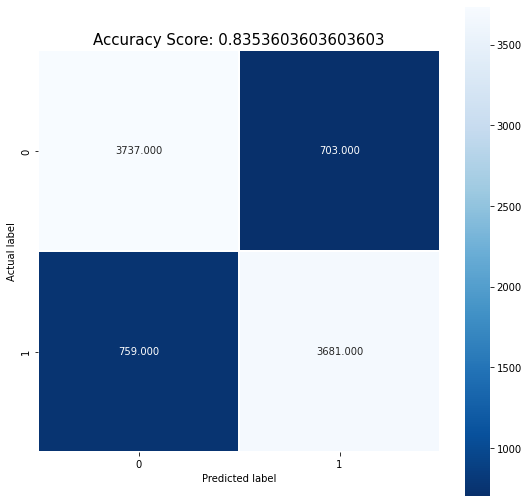

In [ ]:
sns_cm(cm_tfidf, accuracy_test_tfidf)

### Explore Results

In [ ]:
print('Classes of the model: ',classifier_tfidf.classes_)
print(80*'-')
print('Shape of the coefficients of the model (categories x vocabulary size): ',classifier_tfidf.coef_.shape)
print(80*'-')
NN = 10
# Get the 10 (here: NN, which you can adjust yourself) ids of the words with highest weights per category
top_words_1 = np.argsort(classifier_tfidf.coef_,axis=1)[:,-NN:]
top_words_0 = np.argsort(-classifier_tfidf.coef_,axis=1)[:,-NN:]

# Get the vocabulary of the model (mapping of words to ids):
voc = vectorizer_tfidf.vocabulary_
# Get the inverse vocabulary to map the ids of the words to the words:
inv_voc = {v: k for k, v in voc.items()}

Classes of the model:  [0 1]
--------------------------------------------------------------------------------
Shape of the coefficients of the model (categories x vocabulary size):  (1, 10000)
--------------------------------------------------------------------------------


In [ ]:
top_words_1, top_words_0

(array([[2535, 4048, 6531, 8879, 8255, 2922, 3966, 3696, 4978, 5176]]),
 array([[6054,  377, 9085, 6471, 6983, 1036, 4209,  258, 7694, 5761]]))

In [ ]:
t = ''
for i in range(NN):
  t += inv_voc[top_words_1[0,i]]
  if i!=NN:
      t+=', '
print(t)

dream, heart, people, thing, soul, every, happiness, god, life, love, 


In [ ]:
t = ''
for i in range(NN):
  t += inv_voc[top_words_0[0,i]]
  if i!=NN:
      t+=', '
print(t)

north, although, told, passed, program, born god, however, af, said, mr, 


### Test Prediction

In [ ]:
text_test_tfidf = [utils_preprocess_text(text) for text in text_test]
text_test_tfidf

['a journey of a thousand mile begin with a single step',
 'are you beginning a journey of a thousand step tomorrow',
 'the post cited people familiar with the investigation a saying that federal agent were looking for classified document related to nuclear weapon',
 'but it turn out that trump did take such material from the white house',
 'no one will reap except what they sow']

In [ ]:
pd.DataFrame(data={
    'Text': text_test,
    'Normal': model_tfidf.predict_proba(text_test_tfidf)[:, 0],
    'Quotation': model_tfidf.predict_proba(text_test_tfidf)[:, 1],
    'Prediction': model_tfidf.predict(text_test_tfidf),
    'Truth': truth_test
})

,Text,Normal,Quotation,Prediction,Truth
0,A journey of a thousand miles begins with a si...,0.375295,0.624705,1,1
1,Are you beginning a journey of a thousand step...,0.219331,0.780669,1,0
2,The Post cited people familiar with the invest...,0.916952,0.083048,0,0
3,But it turns out that Trump did take such mate...,0.931681,0.068319,0,0
4,No one will reap except what they sow.,0.486695,0.513305,1,1


### Save Model

In [ ]:
pickle.dump(model_tfidf, open('tfidf.model', 'wb'))
# files.download('tfidf.model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load and test the saved model.

In [ ]:
model_tfidf2 = pickle.load(open('tfidf.model', 'rb'))
model_tfidf2.predict(text_test_tfidf)

array([1, 1, 0, 0, 1])

## Deep Learning - RNN Model

### Split Data

In [ ]:
X_tf = df['text']
y_tf = df['category']

X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.3, random_state=42, stratify=df['category'])

In [ ]:
corpus = X_tf_train
max_words = 30000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

### Explore Data

In [ ]:
max_len = 200

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n = 10
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])

Shape:  (20720, 200)
----------------------------------------------------------------------------------------------------
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

### Pretrained Model

In [ ]:
w2v = api.load("word2vec-google-news-300")
w2v['example'].shape

[==================================================] 100.0% 1662.8/1662.8MB downloaded


(300,)

In [ ]:
assert max_words >= len(reverse_voc)

In [ ]:
emb_matrix=np.zeros((max_words+1, 300))

for i in range(len(reverse_voc)):
    w = reverse_voc[i+1]
    if w in w2v:
        emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

### Build Model

In [ ]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape,name='input')
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(1 ,activation='sigmoid', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          9000300   
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               37920     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 1)                 65        
                                                             

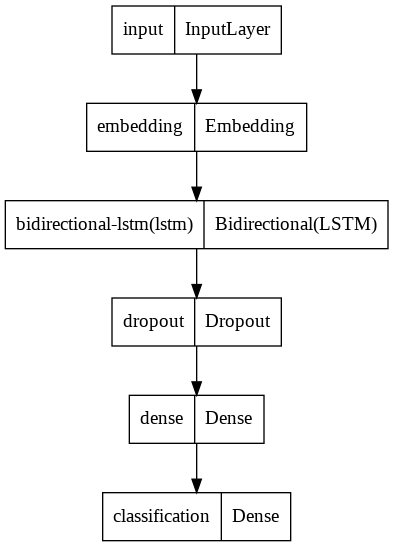

In [ ]:
plot_model(model)

### Train Model

In [ ]:
start_time = datetime.now()

history = model.fit(X_tf_train_seq, y_tf_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/10
324/324 [==============================] - 96s 282ms/step - loss: 0.3941 - accuracy: 0.8323 - val_loss: 0.3258 - val_accuracy: 0.8643
Epoch 2/10
324/324 [==============================] - 91s 281ms/step - loss: 0.3239 - accuracy: 0.8655 - val_loss: 0.3026 - val_accuracy: 0.8740
Epoch 3/10
324/324 [==============================] - 92s 284ms/step - loss: 0.2927 - accuracy: 0.8803 - val_loss: 0.2971 - val_accuracy: 0.8803
Epoch 4/10
324/324 [==============================] - 91s 281ms/step - loss: 0.2736 - accuracy: 0.8854 - val_loss: 0.3019 - val_accuracy: 0.8766
Epoch 5/10
324/324 [==============================] - 91s 281ms/step - loss: 0.2599 - accuracy: 0.8933 - val_loss: 0.3152 - val_accuracy: 0.8749
Epoch 6/10
324/324 [==============================] - 90s 278ms/step - loss: 0.2453 - accuracy: 0.9011 - val_loss: 0.3706 - val_accuracy: 0.8351
Epoch 7/10
324/324 [==============================] - 92s 282ms/step - loss: 0.2353 - accuracy: 0.9050 - val_loss: 0.3123 - val_ac

### Evaluate Model

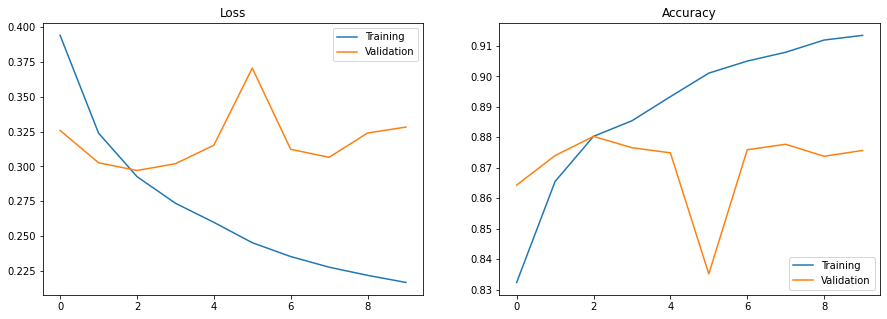

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [ ]:
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_rnn))

Accuracy Training data: 91.3%
Accuracy Test data: 87.6%
Training time: 926.0s


### Confusion Matrix

In [ ]:
predicted_test_rnn = model.predict(X_tf_test_seq).reshape(-1)
predicted_test_rnn = [1 if prob > 0.5 else 0 for prob in predicted_test_rnn]

In [ ]:
cm_rnn = confusion_matrix(y_tf_test, predicted_test_rnn)
cm_rnn

array([[3815,  625],
       [ 479, 3961]])

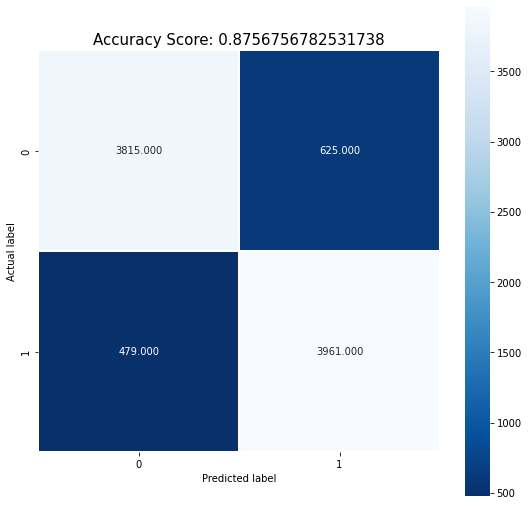

In [ ]:
sns_cm(cm_rnn, history.history['val_accuracy'][-1])

### Test Prediction

In [ ]:
text_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(text_test), maxlen=max_len)

In [ ]:
text_test_seq.shape

(5, 200)

In [ ]:
text_test_seq[0, :]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
text_test_prob = model.predict(text_test_seq).reshape(-1)
text_test_prob

array([9.7595060e-01, 9.7915041e-01, 3.3354759e-04, 1.9159019e-02,
       9.7355378e-01], dtype=float32)

In [ ]:
text_test_prediction = [1 if prob > 0.5 else 0 for prob in text_test_prob]
text_test_prediction

[1, 1, 0, 0, 1]

In [ ]:
pd.DataFrame(data={
    'Text': text_test,
    'Probability': text_test_prob,
    'Prediction': text_test_prediction,
    'Truth': truth_test
})

,Text,Probability,Prediction,Truth
0,A journey of a thousand miles begins with a si...,0.975951,1,1
1,Are you beginning a journey of a thousand step...,0.979150,1,0
2,The Post cited people familiar with the invest...,0.000334,0,0
3,But it turns out that Trump did take such mate...,0.019159,0,0
4,No one will reap except what they sow.,0.973554,1,1


### Save Model

In [ ]:
pickle.dump(corpus, open('corpus.model', 'wb'))
# files.download('corpus.model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('rnn.h5')
# files.download('rnn.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load and test the saved model.

In [ ]:
model2 = load_model('rnn.h5')
text_test_prob2 = model2.predict(text_test_seq).reshape(-1)
text_test_prob2

array([9.7595060e-01, 9.7915041e-01, 3.3354759e-04, 1.9159019e-02,
       9.7355378e-01], dtype=float32)

## Deep Learning - BERT Model

In [ ]:
X_bert = df['text']
y_bert = df['category']

n = 100

In [ ]:
tokenizer_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_bert = [tokenizer_bert(text, padding='max_length', max_length = 128, truncation=True)['input_ids'] for text in X_bert]
X_bert = np.array(X_bert, dtype='int32')

### Split Data

In [ ]:
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(X_bert, y_bert, test_size=0.3, random_state=42, stratify=df['category'])
print('Shape of training data: ',X_bert_train.shape)

Shape of training data:  (20720, 128)


In [ ]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


### Explore Data

In [ ]:
sample = X_bert_train[0:5]
print('Object type: ', type(dbert(sample)))
print('Output format (shape): ',dbert(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert(sample)[0][:,0,:].shape)

Object type:  <class 'transformers.modeling_tf_outputs.TFBaseModelOutput'>
Output format (shape):  (5, 128, 768)
Output used as input for the classifier (shape):  (5, 768)


### Build Model

In [ ]:
input_ids_in = layers.Input(shape=(128,), name='input_token', dtype='int32')

x = dbert(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(1, activation='sigmoid', name='classification')(x)

dmodel = models.Model(inputs=input_ids_in, outputs = x)

dmodel.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
dmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 128)]             0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 128,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                           

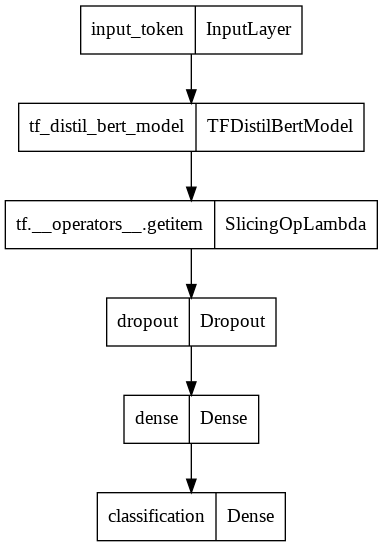

In [ ]:
plot_model(dmodel)

### Train Model

In [ ]:
start_time = datetime.now()
history = dmodel.fit(X_bert_train, y_bert_train, batch_size=32, shuffle=True, epochs=5, validation_data=(X_bert_test, y_bert_test))
end_time = datetime.now()

training_time_bert = (end_time - start_time).total_seconds()

Epoch 1/5
648/648 [==============================] - 6478s 10s/step - loss: 0.5104 - accuracy: 0.7415 - val_loss: 0.3700 - val_accuracy: 0.8465
Epoch 2/5
648/648 [==============================] - 6459s 10s/step - loss: 0.4572 - accuracy: 0.7847 - val_loss: 0.3936 - val_accuracy: 0.8232
Epoch 3/5
648/648 [==============================] - 6505s 10s/step - loss: 0.4461 - accuracy: 0.7921 - val_loss: 0.3427 - val_accuracy: 0.8560
Epoch 4/5
648/648 [==============================] - 6479s 10s/step - loss: 0.4475 - accuracy: 0.7942 - val_loss: 0.4247 - val_accuracy: 0.7796
Epoch 5/5
648/648 [==============================] - 6432s 10s/step - loss: 0.4449 - accuracy: 0.7925 - val_loss: 0.3251 - val_accuracy: 0.8807


### Evaluate Model

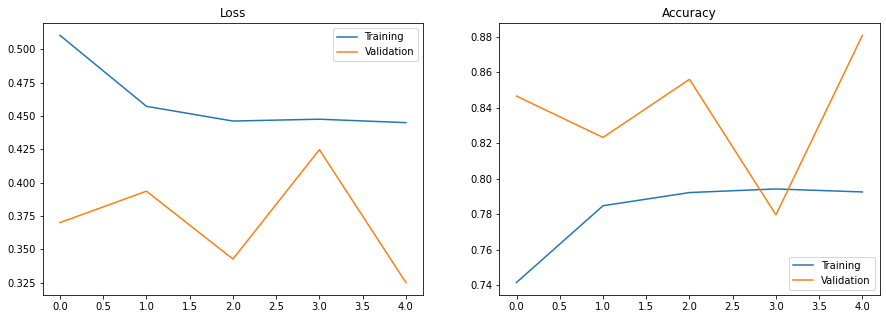

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [ ]:
accuracy_bert = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_bert, training_time_bert/60))

Accuracy Training data: 79.2%
Accuracy Test data: 88.1%
Training time: 32369.6s (or 539.5 minutes)


### Confusion Matrix

In [ ]:
predicted_test_bert = dmodel.predict(X_bert_test).reshape(-1)
predicted_test_bert = [1 if prob > 0.5 else 0 for prob in predicted_test_bert]

In [ ]:
cm_bert = confusion_matrix(y_bert_test, predicted_test_bert)
cm_bert

array([[4019,  421],
       [ 638, 3802]])

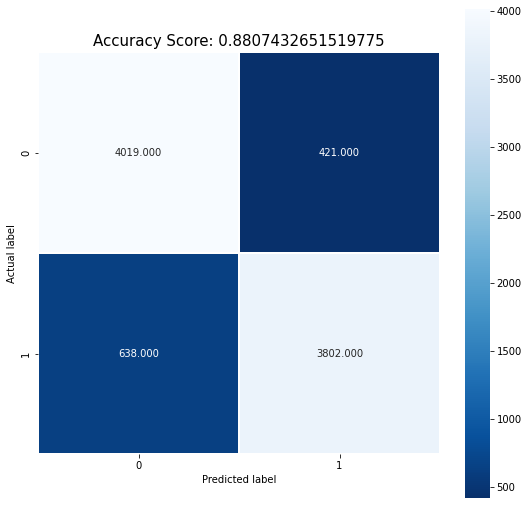

In [ ]:
sns_cm(cm_bert, history.history['val_accuracy'][-1])

### Test Prediction

In [ ]:
text_test_bert = [tokenizer_bert(text, padding='max_length', max_length = 128, truncation=True)['input_ids'] for text in text_test]
text_test_bert = np.array(text_test_bert, dtype='int32')

In [ ]:
text_test_prob = dmodel.predict(text_test_bert).reshape(-1)
text_test_prob

array([0.44601336, 0.8191906 , 0.00509623, 0.1234535 , 0.47522414],
      dtype=float32)

In [ ]:
text_test_prediction = [1 if prob > 0.5 else 0 for prob in text_test_prob]
text_test_prediction

[0, 1, 0, 0, 0]

In [ ]:
pd.DataFrame(data={
    'Text': text_test,
    'Probability': text_test_prob,
    'Prediction': text_test_prediction,
    'Truth': truth_test
})

,Text,Probability,Prediction,Truth
0,A journey of a thousand miles begins with a si...,0.446013,0,1
1,Are you beginning a journey of a thousand step...,0.819191,1,0
2,The Post cited people familiar with the invest...,0.005096,0,0
3,But it turns out that Trump did take such mate...,0.123453,0,0
4,No one will reap except what they sow.,0.475224,0,1


### Save Model

In [ ]:
dmodel.save('bert.h5')
# files.download('bert.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load and test the saved model.

In [ ]:
dmodel2 = load_model('bert.h5')
text_test_prob2 = dmodel2.predict(text_test_bert).reshape(-1)
text_test_prob2

## Compare Models

In [ ]:
method = ['TF-IDF', 'RNN', 'BERT']
accuracy = [accuracy_tfidf, accuracy_rnn, accuracy_bert]
accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]
training_time = [round(training_time_tfidf,1), round(training_time_rnn,1), round(training_time_bert,1)]
training_time_rounded = [round(tt,1) for tt in training_time]
training_time = np.array(training_time)
training_time_x = list(training_time /min(training_time))
training_time_x = [str(round(ttx,1))+'x' for ttx in training_time_x]

dict = {'Method' : method,
        'Accuracy' : accuracy,
        'Training Time [s]' : training_time_rounded,
        'Training Time [x]' : training_time_x}
df = pd.DataFrame(dict)
display(df)

,Method,Accuracy,Training Time [s],Training Time [x]
0,TF-IDF,83.5%,4.9,1.0x
1,RNN,87.6%,926.0,189.0x
2,BERT,88.1%,32369.6,6606.0x
